# SMART Metrics Forecasting

In previous notebooks in this project, we explored how machine learning models can be trained to predict whether a hard drive would fail or not in a given future time interval. The ceph team believes that in addition to the predictions provided by these models, another piece of information that users would find helpful is the forecast of values of specific SMART metrics coming from their hard drives.

In this notebook, we explore how time series forecasting models can be used to predict future values of SMART metrics.

In [2]:
# imports
import warnings
warnings.filterwarnings("ignore")

import pdb
import datetime as dt
from IPython.display import display

import numpy as np
import pandas as pd

import dask.dataframe as dd
from dask.diagnostics import ProgressBar

import seaborn as sns; sns.set()
from matplotlib import pyplot as plt

from fbprophet import Prophet

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, BayesianRidge, Lasso

In [3]:
# dask tasks progress bar
pbar = ProgressBar()
pbar.register()

# Read Data

In this section we'll read in the data to be used for training models. For this notebook, we'll use the open source backblaze hard drive dataset. Since the dataset is quite large, it might not fit in memory for all devices. So we'll use dask for lazy and parallel processing. Note that we are only using one quarter worth of data for this POC, but we can increase this for production models.

In [4]:
# read df and keep seagate data
df = dd.read_parquet(
    path='data_Q3_2020_parquet',
)
df = df[(df['model'].str.startswith('S')) | (df['model'].str.startswith('ZA'))]

In [5]:
# failed vs working serials
failed_serials = df[df['failure']==1]['serial_number'].unique().compute().values
all_serials = df['serial_number'].unique().compute().values
working_serials = np.setdiff1d(all_serials, failed_serials)

[########################################] | 100% Completed | 36.9s
[########################################] | 100% Completed | 33.9s


# Clean Data

In this section we will clean up the data. We'll begin with a small set of smart metrics to use for training (`smart_stats_to_keep`). Then we'll determine which columns have the most amount of missing data, and if this missing data is specific to models. Based on this information we'll refine the smart metrics being kept in the dataset (i.e. update the `smart_stats_to_keep` and re-rerun the following cells). Finally, from the results in the analysis here, we'll determine data from which serial numbers (i.e. hard drives) should be kept so that we have a clean dataset.

In [6]:
# set which columns are metadata and which ones are smart attribuetes
meta_cols = ['date', 'serial_number', 'model', 'capacity_bytes', 'failure']

# set which columns to use in analysis
# NOTE: this determined based on backblaze research, ibm paper, and SMART wiki
smart_stats_to_keep = [5, 187, 188, 197, 198]
smart_cols = [f'smart_{i}_raw' for i in smart_stats_to_keep]
smart_cols += [f'smart_{i}_normalized' for i in smart_stats_to_keep]

## Failed Drives Data

In [7]:
# how much data is missing, device-wise and feature-wise
serialwise_featurewise_pct_nans = df[df['serial_number'].isin(failed_serials)][['serial_number']+smart_cols]\
        .groupby('serial_number')\
        .apply(lambda x: x.isna().mean())\
        .compute()

mean_serialwise_pct_nans = serialwise_featurewise_pct_nans.mean(axis=1).sort_values(ascending=False)
mean_serialwise_pct_nans.head(15)

[########################################] | 100% Completed | 42.5s


serial_number
7LZ022BP          0.909091
7LZ045HN          0.909091
S2ZYJ9GGB04771    0.363636
S2ZYJ9GGB04761    0.363636
S2ZYJ9FFB18437    0.363636
S2ZYJ9CF504020    0.363636
S2ZYJ9FG404851    0.363636
S2ZYJ9KG303913    0.363636
ZA180XLA          0.014430
ZHZ3SPDW          0.000000
ZA18GX05          0.000000
ZCH080S9          0.000000
ZA12MET8          0.000000
ZA180Q9Q          0.000000
ZJV1BTSY          0.000000
dtype: float64

In [8]:
# peek at a few samples to better understand how the nans occur

# dive with 90% data missing
print('7LZ022BP')
print(df[df['serial_number']=='7LZ022BP'][smart_cols].isna().mean().compute().sort_values(ascending=False))

# drive with 1% data missing
print('ZA180XLA')
print(df[df['serial_number']=='ZA180XLA'][smart_cols].isna().mean().compute().sort_values(ascending=False))

# drive with 30% data missing
print('S2ZYJ9GGB04771')
print(df[df['serial_number']=='S2ZYJ9GGB04771'][smart_cols].isna().mean().compute().sort_values(ascending=False))

7LZ022BP
[########################################] | 100% Completed | 33.8s
smart_198_normalized    1.0
smart_197_normalized    1.0
smart_188_normalized    1.0
smart_187_normalized    1.0
smart_5_normalized      1.0
smart_198_raw           1.0
smart_197_raw           1.0
smart_188_raw           1.0
smart_187_raw           1.0
smart_5_raw             1.0
dtype: float64
ZA180XLA
[########################################] | 100% Completed | 32.1s
smart_198_normalized    0.015873
smart_197_normalized    0.015873
smart_188_normalized    0.015873
smart_187_normalized    0.015873
smart_5_normalized      0.015873
smart_198_raw           0.015873
smart_197_raw           0.015873
smart_188_raw           0.015873
smart_187_raw           0.015873
smart_5_raw             0.015873
dtype: float64
S2ZYJ9GGB04771
[########################################] | 100% Completed | 32.9s
smart_188_normalized    1.0
smart_187_normalized    1.0
smart_188_raw           1.0
smart_187_raw           1.0
smart_198_n

**NOTE** From above samples we can see that nans occur either when a very few number of rows are missing, or when entire columns are missing.

In [9]:
# keep only devices that have no missing data
failed_ts_df = df[
    df['serial_number'].isin(
        mean_serialwise_pct_nans[mean_serialwise_pct_nans==0].index
    )
][meta_cols + smart_cols].compute()

[########################################] | 100% Completed | 32.5s


## Working Drives Data

In [10]:
# how much data is missing, device-wise and feature-wise 
serialwise_featurewise_pct_nans = df[df['serial_number'].isin(working_serials)][['serial_number']+smart_cols]\
        .groupby('serial_number')\
        .apply(lambda x: x.isna().mean())\
        .compute()

mean_serialwise_pct_nans = serialwise_featurewise_pct_nans.mean(axis=1).sort_values(ascending=False)
mean_serialwise_pct_nans.head(15)

[########################################] | 100% Completed |  3min  9.5s


serial_number
7LZ01GHG    0.909091
7LZ01NDE    0.909091
7LZ032RA    0.909091
7LZ029KM    0.909091
NB120H9S    0.909091
NB1206GH    0.909091
7QT01D0F    0.909091
7QT01BPW    0.909091
7QT00H3G    0.909091
7LZ047MH    0.909091
7LZ045BC    0.909091
7LZ044SF    0.909091
7LZ036NC    0.909091
7LZ036LY    0.909091
7LZ02ZPX    0.909091
dtype: float64

In [11]:
# downsample working drives data - randomly select for now, use clustering in
# later improvement iterations
pct_working_to_keep = 0.00125
num_working_to_keep = int(pct_working_to_keep*len(working_serials))

# keep devices that have no missing data
working_ts_df = df[
    df['serial_number'].isin(
        mean_serialwise_pct_nans[mean_serialwise_pct_nans==0].index[:num_working_to_keep]
    )
][meta_cols + smart_cols].compute()

[########################################] | 100% Completed | 38.8s


In [12]:
# amount of clean data left to work with
working_ts_df.shape, failed_ts_df.shape

((12405, 15), (11735, 15))

In [13]:
# how much failing drive data do we lose?
dd.compute(df[df['serial_number'].isin(failed_serials)].shape)

[########################################] | 100% Completed | 38.1s


((12242, 131),)

In [14]:
# wont need dask anymore
pbar.unregister()

## Results

By dropping nans, we only lost about 4% of the data (for failed hard drives). Since this does not seem like a completely unreasonable number, we won't do any other data cleaning gymnastics here. The data that we have now is clean and ready for building forecasting models.

## Build Forecasting Models

In this section we will create forecasting models using the clean data from above section. You can play around with the these variables in the cell below to configure the prediction settings.

- `Y_COLS`: The metric to forecast. Since smart 5 was determined to be a valueable indicator of failure, we'll use smart 5 as the default.
- `X_COLS`: Other features available. Some time series models can make use of other features too for generating a forecast. We will use smart 10, 187, 188, 197 and 198 as these additional features. These were determined to be useful from Google research, IBM research, backblaze, and the smart metrics wiki.
- `NDAYS_DATA`: How many days of data available in at runtime. Since the `diskprediction_local` module of ceph stores only 6 days of smart data, our models will only have that much data available.
- `NDAYS_TO_PREDICT`: How many days into the future to forecast. Since we have a short amount of historical data, we will be forecasting for a short period too.

# Metric SMART 5

In the following cells, we will predict the future values of the SMART 5 Metric. SMART 5 specifies the Reallocated Sectors Count for the disk, which is the count of the bad sectors that have been found and remapped. 

In [15]:
# training setup config
Y_COLS = ['smart_5_normalized']
y_smart_stats = set([col.split('_')[1] for col in Y_COLS])

X_COLS = [c for c in smart_cols if c.split('_')[1] not in y_smart_stats]

NDAYS_DATA = 6
NDAYS_TO_PREDICT = 6

In [16]:
# set date column as index
working_ts_df = working_ts_df.set_index('date')
failed_ts_df = failed_ts_df.set_index('date')

## Baseline

In this section we will fit baseline models for the forecasting task. We will compare the performance of the ML models with this baseline to gauge how informative are the models. The baseline model here is one that predicts the next N days will be the same as today.

In [17]:
def get_baseline_mses_windowwise(drive_ts):
    """
    Predict the next N days the value will be same as today.
    Calculate MSE at the end of each training window
    """
    mses = pd.Series(index=drive_ts.index)
    for end_idx in range(NDAYS_DATA-1, len(drive_ts)):
        mses.iloc[end_idx] = ((drive_ts[Y_COLS[0]].iloc[end_idx+1: end_idx+1+NDAYS_TO_PREDICT] - drive_ts[Y_COLS[0]].iloc[end_idx])**2).mean()
        
    return mses

### Failed Drives

In [18]:
# calculate baseline
baseline_mses = failed_ts_df.groupby('serial_number').apply(get_baseline_mses_windowwise)

# df to store all results
all_mses = baseline_mses.to_frame('mse_baseline')

# average mse across days
print('Average MSE for each drive:\n\n', baseline_mses.mean(level=0), end='\n\n')

Average MSE for each drive:

 serial_number
S300WFGR          NaN
S300Z4TZ     0.031410
S300Z7P1     0.000000
S301FDQW    10.322619
S301GMWQ     0.000000
              ...    
ZLW0G6CE     0.000000
ZLW0G6FJ          NaN
ZLW0GK7E     0.000000
ZLW0GKE4     0.000000
ZLW0GPC5          NaN
Length: 272, dtype: float64



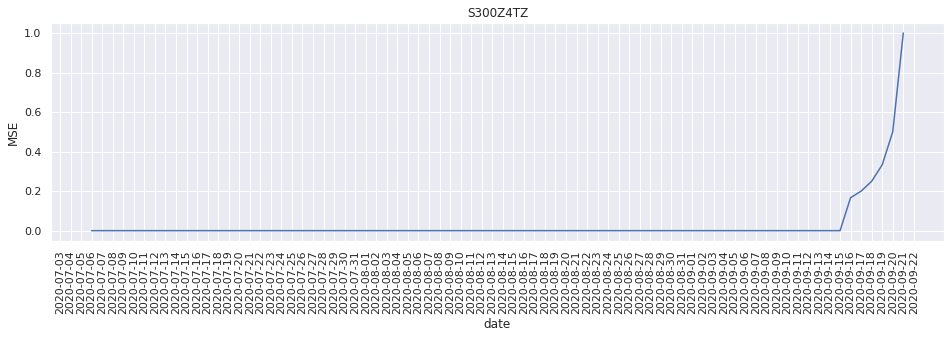

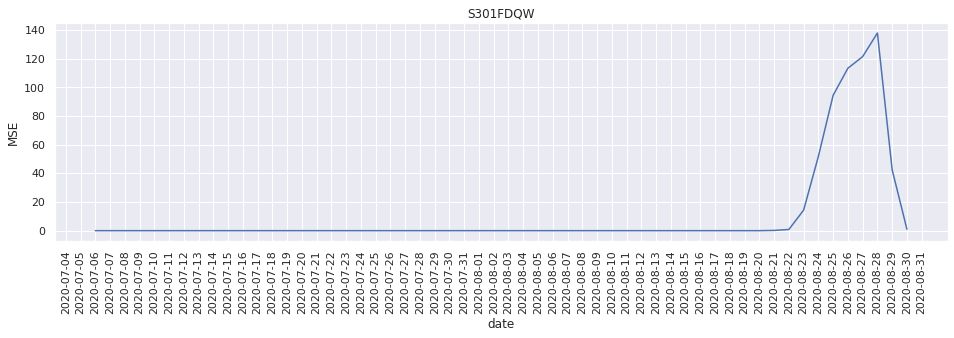

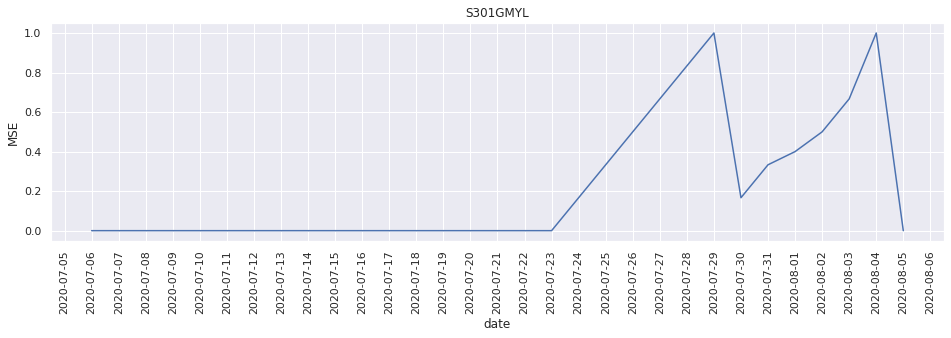

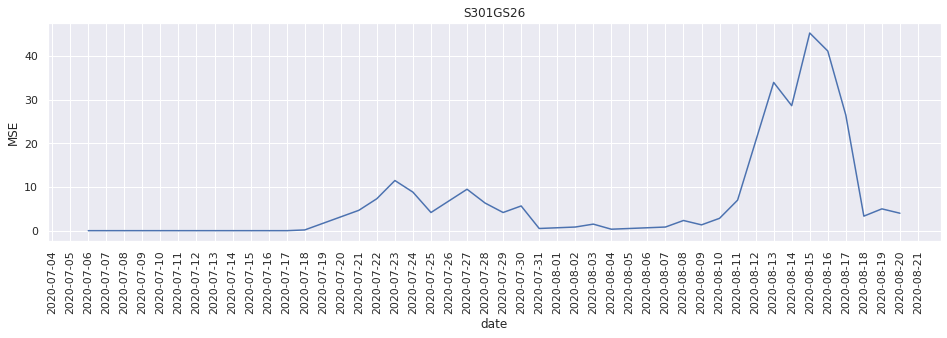

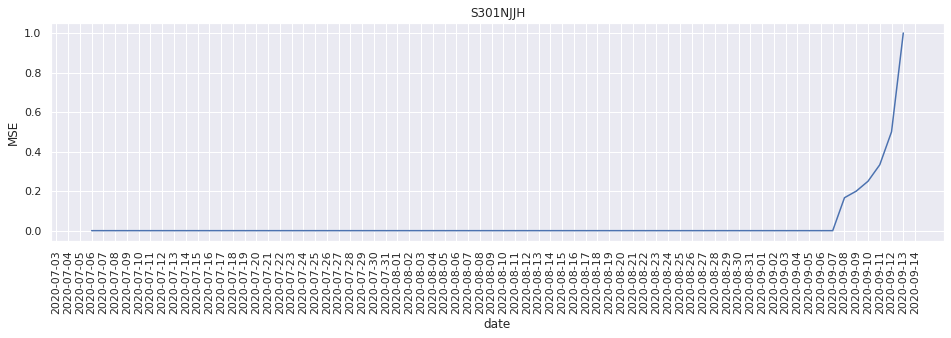

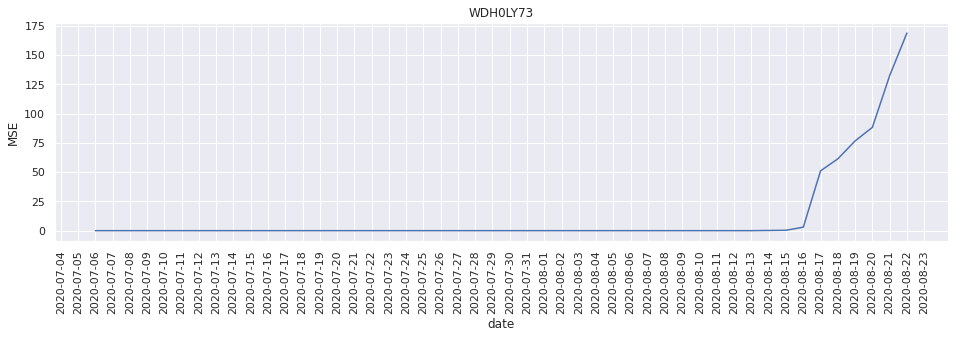

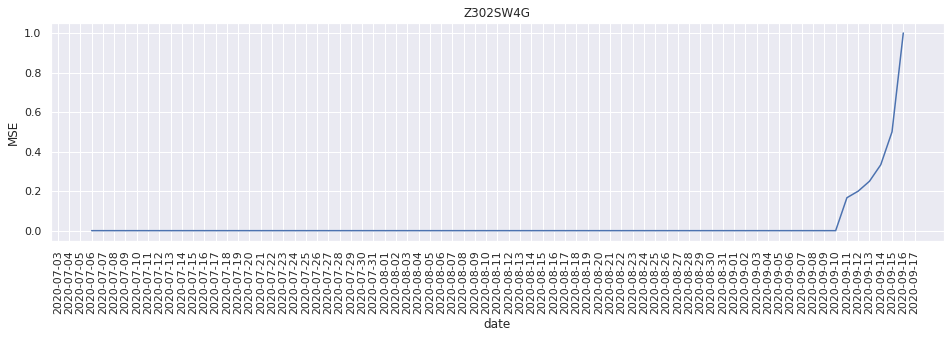

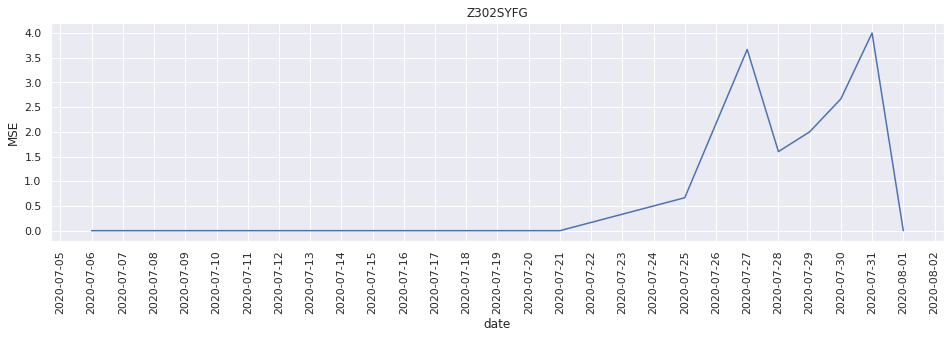

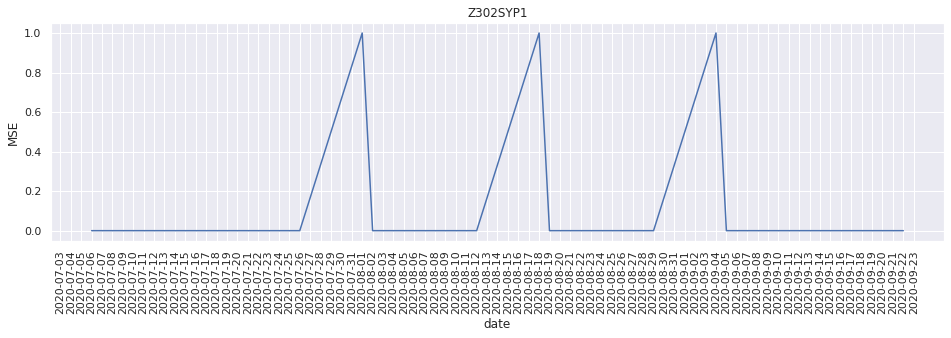

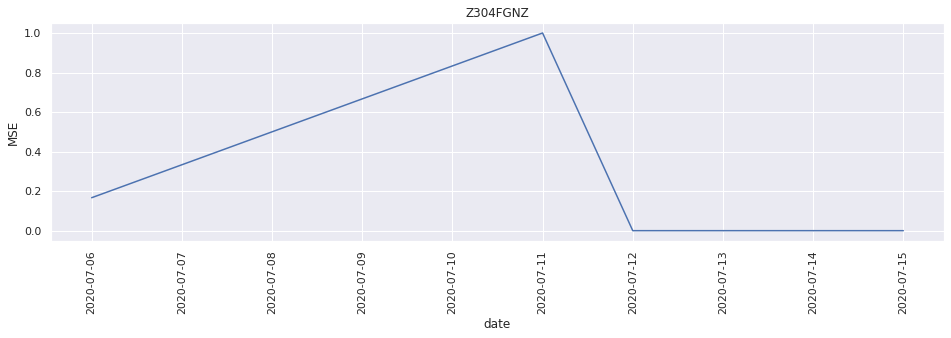

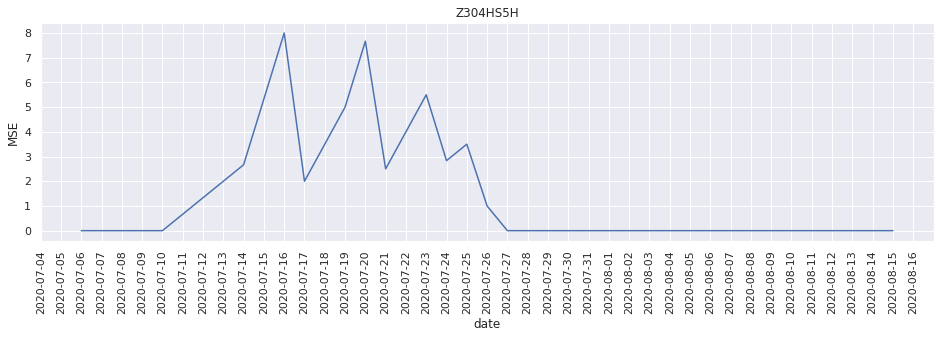

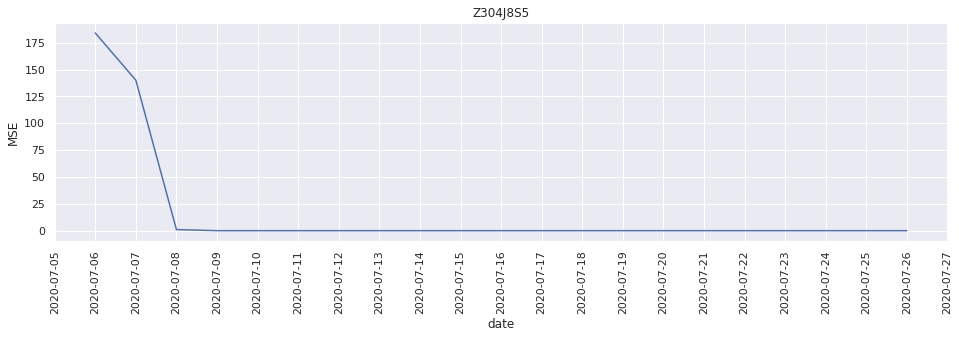

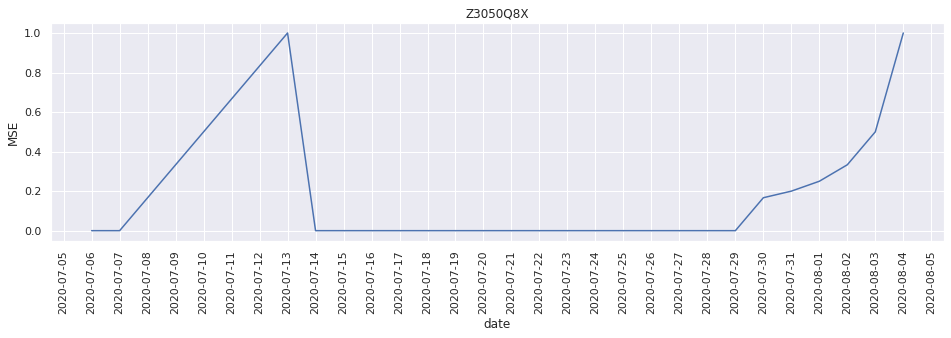

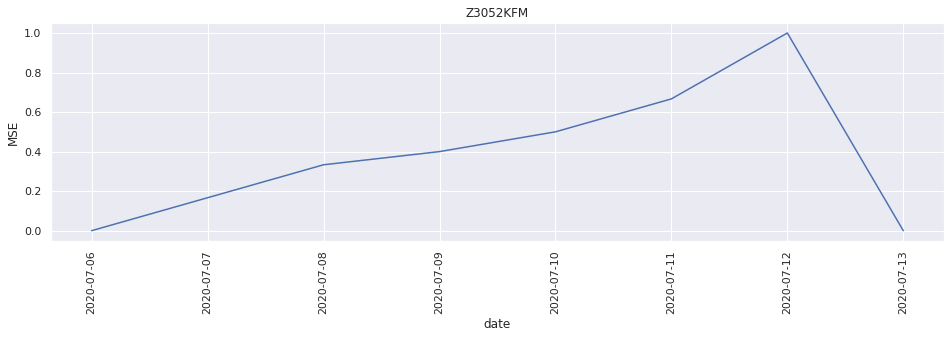

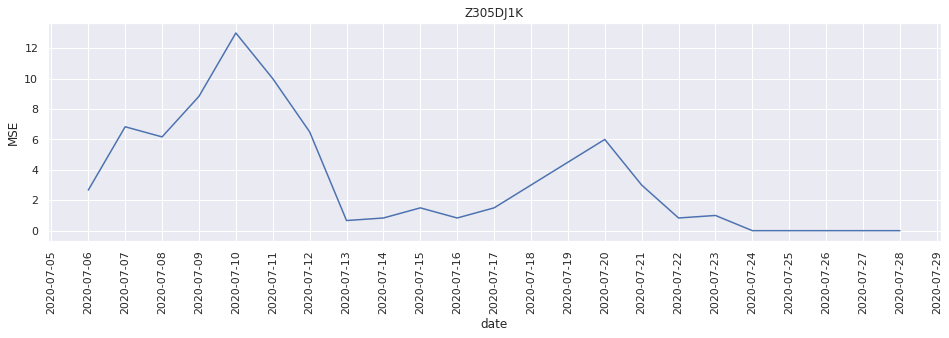

In [19]:
# visualize how mses change over time when using baseline strategy
def visualize_mses(mses, to_plot = 15):
    i = 0
    for ser in mses.index.get_level_values(0).unique():
        # get mse for each day/window
        ser_mses = mses.loc[ser]

        # dont plot if all nans
        if not ser_mses.isna().all():

            # dont plot if the metric to predict has had the same value till fail
            if failed_ts_df[failed_ts_df['serial_number']==ser][Y_COLS[0]].std():
                fig, ax = plt.subplots(figsize=(16, 4))
                sns.lineplot(
                    ax=ax,
                    x=ser_mses.index,
                    y=ser_mses.values,
                )
                plt.title(ser)
                plt.ylabel('MSE')
                plt.xticks(rotation=90)
                plt.show()

                # dont plot everything
                i += 1
                if i==to_plot:
                    break
visualize_mses(baseline_mses)

### Results

From the above graphs, we can see that the baseline strategy works fine when the hard drive is healthy i.e. shows no symptoms of failure. However, as it approaches end of life the error in baseline model predictions rises significantly. So it might seem like a good strategy but it actually provides very little information when it is needed the most.

### Working Drives

In [20]:
# calculate baseline for healthy drives
baseline_mses_working = working_ts_df.groupby('serial_number').apply(get_baseline_mses_windowwise)

# df to store all results
all_mses_working = baseline_mses_working.to_frame('mse_baseline')

# average mse across days
print('Average MSE for each drive:\n\n')
display(baseline_mses_working.mean(level=0))

Average MSE for each drive:




serial_number
S300VKRB    0.0
S300VLKS    0.0
S300WE24    0.0
S300WE6K    0.0
S300WEAV    0.0
           ... 
ZHZ656DW    0.0
ZHZ65C16    0.0
ZJV009E3    0.0
ZJV00AR3    0.0
ZR50121P    NaN
Length: 136, dtype: float64

In [21]:
# what is the WORST average mse using baseline strategy
baseline_mses_working.mean(level=0).max()

0.040697674418604654

### Results

From the above results, it seems that baseline model works extremely well for healthy drives (MSE=0 for most hard drives). The graphs in the section above also indicated the same thing - there is barely any unexpected change in these SMART metrics when the drive is healthy. Therefore in the following sections we will evaluate models only on failed data, since any model would likely be decently performant (if not perfect) for healthy drives. 

## Linear Regression

In [22]:
# calculate windowwise mse for ols model for each drive
def get_linreg_mses_windowwise(drive_ts):
    # define model
    model = LinearRegression(
        normalize=True,
    )

    # create dummy exogenous variable (train)
    dummy_xtrain = np.arange(start=0, stop=NDAYS_DATA).reshape(-1, 1)
    
    mses = pd.Series(index=drive_ts.index)
    for end_idx in range(NDAYS_DATA-1, len(drive_ts)-1):
        # create dummy exogenous variable (test)
        dummy_xtest = np.arange(
            start=NDAYS_DATA, 
            stop=NDAYS_DATA + min(NDAYS_TO_PREDICT, len(drive_ts)-end_idx-1),
        ).reshape(-1, 1)

        # fit model
        model.fit(
            X=dummy_xtrain,
            y=drive_ts[[Y_COLS[0]]].iloc[end_idx+1-NDAYS_DATA: end_idx+1],
        )
        
        # predict and get mse
        preds = model.predict(dummy_xtest).flatten()
        mses.iloc[end_idx] = ((drive_ts[Y_COLS[0]].iloc[end_idx+1: end_idx+1+NDAYS_TO_PREDICT] - preds)**2).mean()
    return mses

windowwise_mses_linear = failed_ts_df.groupby('serial_number').apply(get_linreg_mses_windowwise)

In [40]:
def calc_improvement(all_mses, windowwise_mses, mse_algo):
    # update all results df and compare
    updated_df = all_mses.assign(algo=windowwise_mses)
    updated_df = updated_df.rename({'algo': mse_algo}, axis='columns')

    # average mse across days
    mean_mses = updated_df[['mse_baseline', mse_algo]].groupby('serial_number').mean()

    # improvement over baseline
    diff = mean_mses[mse_algo]-mean_mses['mse_baseline']
    mean_mses = mean_mses.reindex(diff.sort_values().index)
    print('Avg. MSE for each drive:')
    display(mean_mses)

    # average overall improvement over baseline
    print('Avg. Improvement =', -diff.mean())
    
    # peek at drive with most improvement
    print('\n peek at drive with most improvement')
    display(updated_df.loc[mean_mses.iloc[0].name])
calc_improvement(all_mses, windowwise_mses_linear, 'linreg_mse')

Avg. MSE for each drive:


,mse_baseline,linreg_mse
serial_number,,
ZCH0EA28,381.806250,148.840343
ZCH0CCSY,736.158333,612.876751
ZJV5M9KA,460.544444,378.915628
ZCH074SE,169.000000,157.084444
ZA1819E9,11.441667,4.145687
...,...,...
ZHZ50G0W,NaN,NaN
ZHZ5W6L4,NaN,NaN
ZL005C4H,NaN,NaN


Avg. Improvement = 1.5228603706772657

 peek at drive with most improvement


,mse_baseline,linreg_mse
date,,
2020-07-01,NaN,NaN
2020-07-02,NaN,NaN
2020-07-03,NaN,NaN
2020-07-04,NaN,NaN
2020-07-05,NaN,NaN
2020-07-06,958.666667,57.512789
2020-07-07,973.333333,59.737506
2020-07-08,479.833333,227.104444
2020-07-09,122.200000,473.360000


## Lasso

In [41]:
# calculate windowwise mse for lasso model for each drive
def get_lasso_mses_windowwise(drive_ts):
    # define model
    model = Lasso(
        normalize=True,
        random_state=42,
    )

    # create dummy exogenous variable (train)
    dummy_xtrain = np.arange(start=0, stop=NDAYS_DATA).reshape(-1, 1)
    
    mses = pd.Series(index=drive_ts.index)
    for end_idx in range(NDAYS_DATA-1, len(drive_ts)-1):
        # create dummy exogenous variable (test)
        dummy_xtest = np.arange(
            start=NDAYS_DATA, 
            stop=NDAYS_DATA + min(NDAYS_TO_PREDICT, len(drive_ts)-end_idx-1),
        ).reshape(-1, 1)

        # fit model
        model.fit(
            X=dummy_xtrain,
            y=drive_ts[[Y_COLS[0]]].iloc[end_idx+1-NDAYS_DATA: end_idx+1],
        )
        
        # predict and get mse
        preds = model.predict(dummy_xtest).flatten()
        mses.iloc[end_idx] = ((drive_ts[Y_COLS[0]].iloc[end_idx+1: end_idx+1+NDAYS_TO_PREDICT] - preds)**2).mean()
    return mses

windowwise_mses_lasso = failed_ts_df.groupby('serial_number').apply(get_lasso_mses_windowwise)

In [42]:
calc_improvement(all_mses, windowwise_mses_lasso, 'lasso_mse')

Avg. MSE for each drive:


,mse_baseline,lasso_mse
serial_number,,
ZCH0EA28,381.806250,89.382469
ZJV5M9KA,460.544444,417.703068
ZCH0CCSY,736.158333,707.688888
S300Z4TZ,0.031410,0.031410
ZCH083F6,0.000000,0.000000
...,...,...
ZHZ50G0W,NaN,NaN
ZHZ5W6L4,NaN,NaN
ZL005C4H,NaN,NaN


Avg. Improvement = 0.1446787476441166

 peek at drive with most improvement


,mse_baseline,lasso_mse
date,,
2020-07-01,NaN,NaN
2020-07-02,NaN,NaN
2020-07-03,NaN,NaN
2020-07-04,NaN,NaN
2020-07-05,NaN,NaN
2020-07-06,958.666667,209.017283
2020-07-07,973.333333,82.382696
2020-07-08,479.833333,64.721416
2020-07-09,122.200000,188.592501


## Bayesian Ridge Regression

In [43]:
# calculate windowwise mse for br model for each drive
def get_br_mses_windowwise(drive_ts):
    # define model
    model = BayesianRidge(
        normalize=True,
    )

    # create dummy exogenous variable (train)
    dummy_xtrain = np.arange(start=0, stop=NDAYS_DATA).reshape(-1, 1)
    
    mses = pd.Series(index=drive_ts.index)
    for end_idx in range(NDAYS_DATA-1, len(drive_ts)-1):
        
        # create dummy exogenous variable (test)
        dummy_xtest = np.arange(
            start=NDAYS_DATA, 
            stop=NDAYS_DATA + min(NDAYS_TO_PREDICT, len(drive_ts)-end_idx-1),
        ).reshape(-1, 1)

        # fit model
        model.fit(
            X=dummy_xtrain,
            y=drive_ts[Y_COLS[0]].iloc[end_idx+1-NDAYS_DATA: end_idx+1],
        )
        
        # predict and get mse
        preds = model.predict(dummy_xtest).flatten()
        
        if np.isnan(preds).any():
            pdb.set_trace()
            
        mses.iloc[end_idx] = ((drive_ts[Y_COLS[0]].iloc[end_idx+1: end_idx+1+NDAYS_TO_PREDICT] - preds)**2).mean()
    return mses

windowwise_mses_br = failed_ts_df.groupby('serial_number').apply(get_br_mses_windowwise)

In [44]:
calc_improvement(all_mses, windowwise_mses_br, 'br_mse')

Avg. MSE for each drive:


,mse_baseline,br_mse
serial_number,,
ZCH0EA28,381.806250,142.547238
ZCH0CCSY,736.158333,635.306334
ZJV5M9KA,460.544444,400.676324
ZA1819E9,11.441667,4.100040
ZCH074SE,169.000000,162.721665
...,...,...
ZHZ50G0W,NaN,NaN
ZHZ5W6L4,NaN,NaN
ZL005C4H,NaN,NaN


Avg. Improvement = 1.364011532336577

 peek at drive with most improvement


,mse_baseline,br_mse
date,,
2020-07-01,NaN,NaN
2020-07-02,NaN,NaN
2020-07-03,NaN,NaN
2020-07-04,NaN,NaN
2020-07-05,NaN,NaN
2020-07-06,958.666667,66.331898
2020-07-07,973.333333,57.570863
2020-07-08,479.833333,219.038516
2020-07-09,122.200000,457.571010


## ARIMA

In [47]:
# calculate windowwise mse for arima model for each drive
def get_arima_mses_windowwise(drive_ts):
    mses = pd.Series(index=drive_ts.index)
    
    for end_idx in range(NDAYS_DATA-1, len(drive_ts)):
        try:
            # init model and train
            model = ARIMA(
                endog=drive_ts[[Y_COLS[0]]].iloc[end_idx+1-NDAYS_DATA: end_idx+1],
                order=(1, 1, 0),
                freq='D',
            )
            model = model.fit()
            
            # forecast and calculate error
            preds = model.forecast(steps=NDAYS_TO_PREDICT)
            mses.iloc[end_idx] = ((drive_ts[Y_COLS[0]].iloc[end_idx+1: end_idx+1+NDAYS_TO_PREDICT] - preds)**2).mean()

        # value errors occur when dates are not continuous
        except ValueError as ve:
            mses.iloc[end_idx] = np.nan
            
    return mses
windowwise_mses_arima = failed_ts_df.groupby('serial_number').apply(get_arima_mses_windowwise)

In [48]:
calc_improvement(all_mses, windowwise_mses_arima, 'arima_mse')

Avg. MSE for each drive:


,mse_baseline,arima_mse
serial_number,,
ZCH0EA28,381.806250,267.692262
ZCH0CCSY,736.158333,661.323586
ZCH074SE,169.000000,145.534586
ZA12RB44,4.000000,0.133154
ZA16DDTZ,9.000000,5.670446
...,...,...
ZHZ50G0W,NaN,NaN
ZHZ5W6L4,NaN,NaN
ZL005C4H,NaN,NaN


Avg. Improvement = 0.7232415431034219

 peek at drive with most improvement


,mse_baseline,arima_mse
date,,
2020-07-01,NaN,NaN
2020-07-02,NaN,NaN
2020-07-03,NaN,NaN
2020-07-04,NaN,NaN
2020-07-05,NaN,NaN
2020-07-06,958.666667,628.750569
2020-07-07,973.333333,524.365544
2020-07-08,479.833333,48.255805
2020-07-09,122.200000,530.488499


## SARIMAX

In [49]:
# calculate windowwise mse for sarimax model for each drive
def get_sarimax_mses_windowwise(drive_ts):
    mses = pd.Series(index=drive_ts.index)

    for end_idx in range(NDAYS_DATA-1, len(drive_ts)):
        try:
            model = SARIMAX(
                endog=drive_ts[[Y_COLS[0]]].iloc[end_idx+1-NDAYS_DATA: end_idx+1],
                order=(1, 1, 0),
                freq='D',
            )
            model = model.fit()
            preds = model.forecast(steps=NDAYS_TO_PREDICT)
            mses.iloc[end_idx] = ((drive_ts[Y_COLS[0]].iloc[end_idx+1: end_idx+1+NDAYS_TO_PREDICT] - preds)**2).mean()
        except ValueError as ve:
            mses.iloc[end_idx] = np.nan
    return mses

windowwise_mses_sarimax = failed_ts_df.groupby('serial_number').apply(get_sarimax_mses_windowwise)

In [50]:
calc_improvement(all_mses, windowwise_mses_sarimax, 'sarimax_mse')

Avg. MSE for each drive:


,mse_baseline,sarimax_mse
serial_number,,
ZCH0EA28,381.806250,267.692262
ZCH0CCSY,736.158333,661.323586
ZCH074SE,169.000000,145.534586
ZA12RB44,4.000000,0.133154
ZA16DDTZ,9.000000,5.670446
...,...,...
ZHZ50G0W,NaN,NaN
ZHZ5W6L4,NaN,NaN
ZL005C4H,NaN,NaN


Avg. Improvement = 0.7232415431034219

 peek at drive with most improvement


,mse_baseline,sarimax_mse
date,,
2020-07-01,NaN,NaN
2020-07-02,NaN,NaN
2020-07-03,NaN,NaN
2020-07-04,NaN,NaN
2020-07-05,NaN,NaN
2020-07-06,958.666667,628.750569
2020-07-07,973.333333,524.365544
2020-07-08,479.833333,48.255805
2020-07-09,122.200000,530.488499


## Prophet

In [51]:
# calculate windowwise mse for sarimax model for each drive
def get_prophet_mses_windowwise(drive_ts):
    mses = pd.Series(index=drive_ts.index)
    for end_idx in range(NDAYS_DATA-1, len(drive_ts)-1):
        try:
            # init prophet model
            model = Prophet(
                n_changepoints=3,
                daily_seasonality=True,
                weekly_seasonality=False,
                yearly_seasonality=False,
                uncertainty_samples=False,
            )

            # fit to historical data (today to today minus NDAYS_TO_PREDICT)
            model.fit(

                drive_ts[Y_COLS].iloc[end_idx+1-NDAYS_DATA: end_idx+1]\
                        .reset_index()\
                        .rename(columns={'date': 'ds', f'{Y_COLS[0]}': 'y'})

            )

            # predict future
            preds = model.predict(
                model.make_future_dataframe(
                    periods=min(NDAYS_TO_PREDICT, len(drive_ts)-end_idx-1),
                    include_history=False,
                )
            )['yhat'].values

            # calculate mean squared error at this date
            mses.iloc[end_idx] = ((drive_ts[Y_COLS[0]].iloc[end_idx+1: end_idx+1+NDAYS_TO_PREDICT].values - preds)**2).mean()
        except ValueError as ve:
            mses.iloc[end_idx] = np.nan
    return mses

windowwise_mses_prophet = failed_ts_df.groupby('serial_number').apply(get_prophet_mses_windowwise)

In [52]:
calc_improvement(all_mses, windowwise_mses_prophet, 'prophet_mse')

Avg. MSE for each drive:


,mse_baseline,prophet_mse
serial_number,,
ZCH0EA28,381.806250,148.774488
ZCH0CCSY,736.158333,591.042024
ZJV5M9KA,460.544444,376.511968
ZA180YNM,62.883333,50.712123
ZCH074SE,169.000000,157.133496
...,...,...
ZHZ50G0W,NaN,NaN
ZHZ5W6L4,NaN,NaN
ZL005C4H,NaN,NaN


Avg. Improvement = 1.695440886904843

 peek at drive with most improvement


,mse_baseline,prophet_mse
date,,
2020-07-01,NaN,NaN
2020-07-02,NaN,NaN
2020-07-03,NaN,NaN
2020-07-04,NaN,NaN
2020-07-05,NaN,NaN
2020-07-06,958.666667,57.550052
2020-07-07,973.333333,59.718423
2020-07-08,479.833333,226.997537
2020-07-09,122.200000,473.553431


From the above experiments it seems like the Prophet model outperforms the rest for SMART 5 metric. However, a simple OLS model works quite well too with its average MSE not too far away from that of Prophet. Nonetheless, Prophet has the advantage of providing confidence intervals, and also account for weekly/daily/yearly seasonality. Therefore it is likely that when the amount of available historical data at runtime is increased, Prophet would perform even better than OLS.

# Metric SMART 187

In the following cells, we will predict the future values of the SMART 187 Metric. SMART 187 specifies the count of errors that could not be recovered using hardware ECC.

In [53]:
# training setup config
Y_COLS = ['smart_187_normalized']
y_smart_stats = set([col.split('_')[1] for col in Y_COLS])

X_COLS = [c for c in smart_cols if c.split('_')[1] not in y_smart_stats]

NDAYS_DATA = 6
NDAYS_TO_PREDICT = 6

In [54]:
# calculate baseline
baseline_mses = failed_ts_df.groupby('serial_number').apply(get_baseline_mses_windowwise)

# df to store all results
all_mses = baseline_mses.to_frame('mse_baseline')

# average mse across days
print('Average MSE for each drive:\n\n', baseline_mses.mean(level=0), end='\n\n')

Average MSE for each drive:

 serial_number
S300WFGR            NaN
S300Z4TZ      32.910256
S300Z7P1       2.544231
S301FDQW     257.093750
S301GMWQ      24.436364
               ...     
ZLW0G6CE    1263.813158
ZLW0G6FJ            NaN
ZLW0GK7E       0.000000
ZLW0GKE4       0.000000
ZLW0GPC5            NaN
Length: 272, dtype: float64



INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


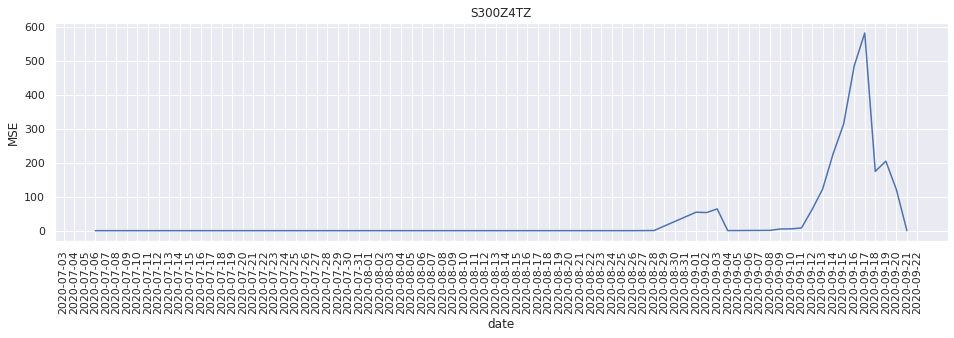

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


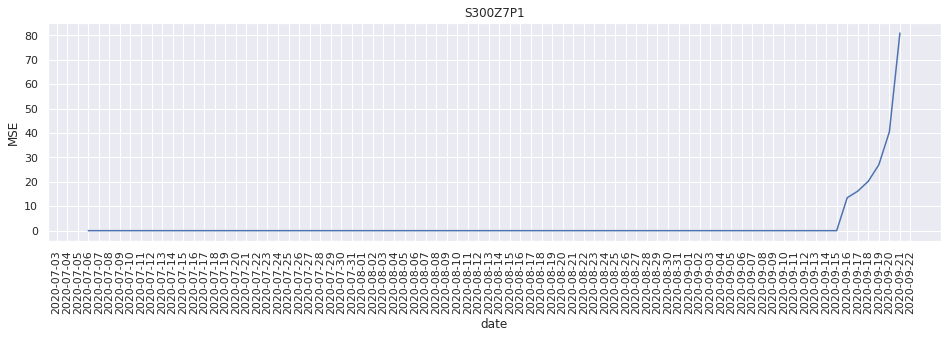

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


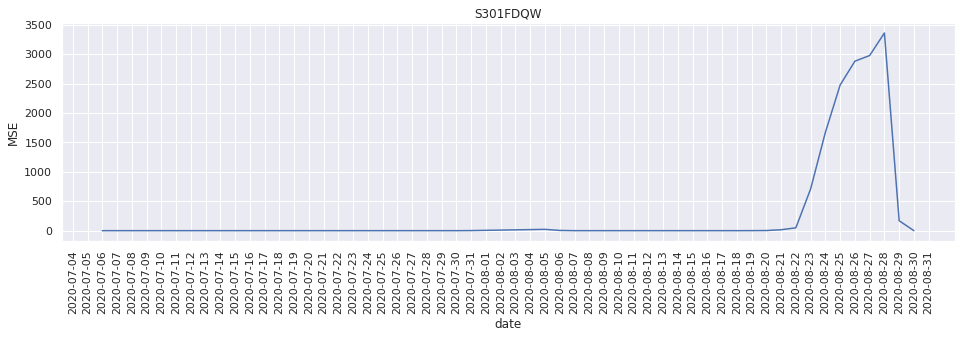

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


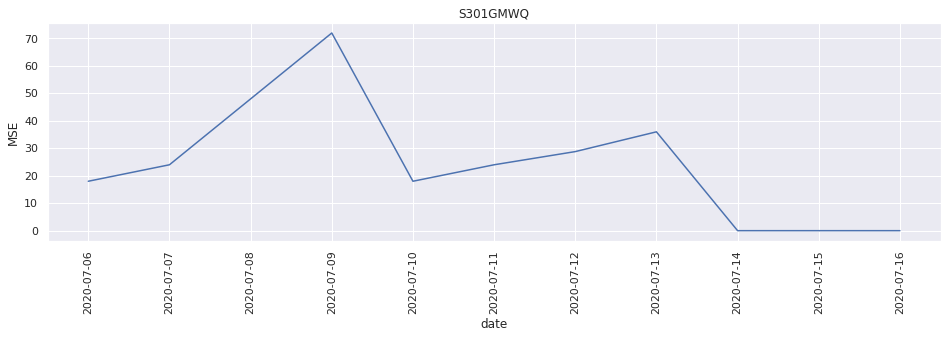

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


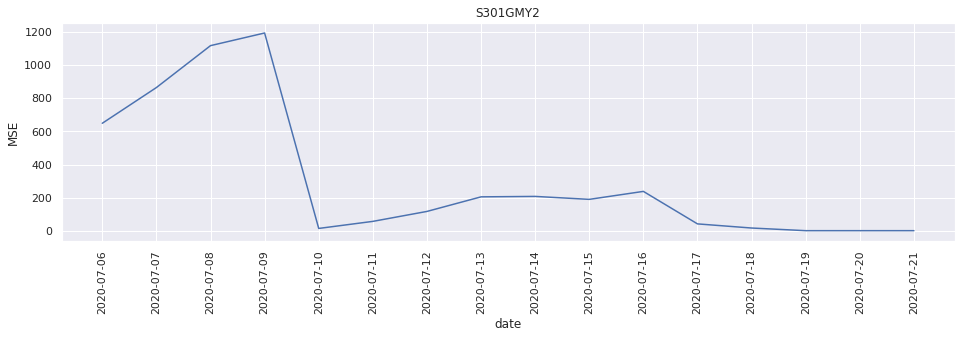

In [55]:
visualize_mses(baseline_mses, 5)

### Working Drives

In [56]:
# calculate baseline for healthy drives
baseline_mses_working = working_ts_df.groupby('serial_number').apply(get_baseline_mses_windowwise)

# df to store all results
all_mses_working = baseline_mses_working.to_frame('mse_baseline')

# average mse across days
print('Average MSE for each drive:\n\n')
display(baseline_mses_working.mean(level=0))

Average MSE for each drive:




serial_number
S300VKRB    0.0
S300VLKS    0.0
S300WE24    0.0
S300WE6K    0.0
S300WEAV    0.0
           ... 
ZHZ656DW    0.0
ZHZ65C16    0.0
ZJV009E3    0.0
ZJV00AR3    0.0
ZR50121P    NaN
Length: 136, dtype: float64

In [57]:
# what is the WORST average mse using baseline strategy
baseline_mses_working.mean(level=0).max()

3.7151162790697674

## Linear Regression

In [58]:
windowwise_mses_linear = failed_ts_df.groupby('serial_number').apply(get_linreg_mses_windowwise)
calc_improvement(all_mses, windowwise_mses_linear, 'linreg_mse')

Avg. MSE for each drive:


,mse_baseline,linreg_mse
serial_number,,
Z3052KFM,2104.193750,1904.334640
ZA180YNM,927.082456,835.112770
Z304JL8D,261.437879,174.055424
Z302SYFG,163.941975,84.107804
ZA180971,185.429167,145.494930
...,...,...
ZHZ50G0W,NaN,NaN
ZHZ5W6L4,NaN,NaN
ZL005C4H,NaN,NaN


Avg. Improvement = -13.544770957108467

 peek at drive with most improvement


,mse_baseline,linreg_mse
date,,
2020-07-01,NaN,NaN
2020-07-02,NaN,NaN
2020-07-03,NaN,NaN
2020-07-04,NaN,NaN
2020-07-05,NaN,NaN
2020-07-06,1958.333333,1871.334785
2020-07-07,2922.500000,2779.653061
2020-07-08,4015.166667,3609.422313
2020-07-09,3723.800000,3170.509751


## Lasso

In [59]:
windowwise_mses_lasso = failed_ts_df.groupby('serial_number').apply(get_lasso_mses_windowwise)
calc_improvement(all_mses, windowwise_mses_lasso, 'lasso_mse')

Avg. MSE for each drive:


,mse_baseline,lasso_mse
serial_number,,
Z304JL8D,261.437879,205.298409
Z302SYFG,163.941975,161.501765
ZCH07RST,112.985526,111.428219
ZA1815CT,0.000000,0.000000
ZCH05TR4,0.000000,0.000000
...,...,...
ZHZ50G0W,NaN,NaN
ZHZ5W6L4,NaN,NaN
ZL005C4H,NaN,NaN


Avg. Improvement = -16.399749054351826

 peek at drive with most improvement


,mse_baseline,lasso_mse
date,,
2020-07-01,NaN,NaN
2020-07-02,NaN,NaN
2020-07-03,NaN,NaN
2020-07-04,NaN,NaN
2020-07-05,NaN,NaN
...,...,...
2020-08-26,90.75,455.673442
2020-08-27,121.00,57.964244
2020-08-28,0.00,300.594005


## Bayesian Ridge Regression

In [60]:
windowwise_mses_br = failed_ts_df.groupby('serial_number').apply(get_br_mses_windowwise)
calc_improvement(all_mses, windowwise_mses_br, 'br_mse')

Avg. MSE for each drive:


,mse_baseline,br_mse
serial_number,,
Z3052KFM,2104.193750,1945.070187
Z304JL8D,261.437879,188.325664
Z302SYFG,163.941975,97.107672
ZA180YNM,927.082456,864.843916
ZA180971,185.429167,155.876973
...,...,...
ZHZ50G0W,NaN,NaN
ZHZ5W6L4,NaN,NaN
ZL005C4H,NaN,NaN


Avg. Improvement = -12.574399183281896

 peek at drive with most improvement


,mse_baseline,br_mse
date,,
2020-07-01,NaN,NaN
2020-07-02,NaN,NaN
2020-07-03,NaN,NaN
2020-07-04,NaN,NaN
2020-07-05,NaN,NaN
2020-07-06,1958.333333,1881.106322
2020-07-07,2922.500000,2843.440680
2020-07-08,4015.166667,3671.497463
2020-07-09,3723.800000,3270.626857


## ARIMA

In [61]:
windowwise_mses_arima = failed_ts_df.groupby('serial_number').apply(get_arima_mses_windowwise)
calc_improvement(all_mses, windowwise_mses_arima, 'arima_mse')

Avg. MSE for each drive:


,mse_baseline,arima_mse
serial_number,,
ZJV024DY,418.429060,158.945946
Z3052KFM,2104.193750,2000.392801
ZA1752L5,884.004545,823.868182
ZA180YNM,927.082456,872.846928
ZCH0CCSY,219.554762,186.018570
...,...,...
ZHZ50G0W,NaN,NaN
ZHZ5W6L4,NaN,NaN
ZL005C4H,NaN,NaN


Avg. Improvement = 1.3287091876332966

 peek at drive with most improvement


,mse_baseline,arima_mse
date,,
2020-07-01,NaN,NaN
2020-07-02,NaN,NaN
2020-07-03,NaN,NaN
2020-07-04,NaN,NaN
2020-07-05,NaN,NaN
...,...,...
2020-09-19,7351.0,NaN
2020-09-20,9604.0,NaN
2020-09-21,0.0,NaN


## SARIMAX

In [62]:
windowwise_mses_sarimax = failed_ts_df.groupby('serial_number').apply(get_sarimax_mses_windowwise)
calc_improvement(all_mses, windowwise_mses_sarimax, 'sarimax_mse')

Avg. MSE for each drive:


,mse_baseline,sarimax_mse
serial_number,,
ZJV024DY,418.429060,158.945946
Z3052KFM,2104.193750,2000.392801
ZA1752L5,884.004545,823.868182
ZA180YNM,927.082456,872.846928
ZCH0CCSY,219.554762,186.018570
...,...,...
ZHZ50G0W,NaN,NaN
ZHZ5W6L4,NaN,NaN
ZL005C4H,NaN,NaN


Avg. Improvement = 1.3287091876332966

 peek at drive with most improvement


,mse_baseline,sarimax_mse
date,,
2020-07-01,NaN,NaN
2020-07-02,NaN,NaN
2020-07-03,NaN,NaN
2020-07-04,NaN,NaN
2020-07-05,NaN,NaN
...,...,...
2020-09-19,7351.0,NaN
2020-09-20,9604.0,NaN
2020-09-21,0.0,NaN


## Prophet

In [63]:
windowwise_mses_prophet = failed_ts_df.groupby('serial_number').apply(get_prophet_mses_windowwise)
calc_improvement(all_mses, windowwise_mses_prophet, 'prophet_mse')

Avg. MSE for each drive:


,mse_baseline,prophet_mse
serial_number,,
Z3052KFM,2104.193750,1791.542133
ZA180YNM,927.082456,835.242244
Z304JL8D,261.437879,178.431901
Z302SYFG,163.941975,84.363744
ZA12CASG,119.248765,81.321330
...,...,...
ZHZ50G0W,NaN,NaN
ZHZ5W6L4,NaN,NaN
ZL005C4H,NaN,NaN


Avg. Improvement = -12.634035302462422

 peek at drive with most improvement


,mse_baseline,prophet_mse
date,,
2020-07-01,NaN,NaN
2020-07-02,NaN,NaN
2020-07-03,NaN,NaN
2020-07-04,NaN,NaN
2020-07-05,NaN,NaN
2020-07-06,1958.333333,1958.333333
2020-07-07,2922.500000,2474.733351
2020-07-08,4015.166667,2929.241579
2020-07-09,3723.800000,3161.276150


From the above experiments, it seems like the Arima and sarimax model performs best for SMART 187 metric. However,  linear regression, lasso, bayesian ridge regression, and prophet performed worse than the baseline model.

# Metric SMART 188

In the following cells, we will predict the future values of the SMART 188 Metric. SMART 188 specifies the count of aborted operations due to HDD timeout. Normally this attribute value should be equal to zero.

In [64]:
# training setup config
Y_COLS = ['smart_188_normalized']
y_smart_stats = set([col.split('_')[1] for col in Y_COLS])

X_COLS = [c for c in smart_cols if c.split('_')[1] not in y_smart_stats]

NDAYS_DATA = 6
NDAYS_TO_PREDICT = 6

In [65]:
# calculate baseline
baseline_mses = failed_ts_df.groupby('serial_number').apply(get_baseline_mses_windowwise)

# df to store all results
all_mses = baseline_mses.to_frame('mse_baseline')

# average mse across days
print('Average MSE for each drive:\n\n', baseline_mses.mean(level=0), end='\n\n')

Average MSE for each drive:

 serial_number
S300WFGR    NaN
S300Z4TZ    0.0
S300Z7P1    0.0
S301FDQW    0.0
S301GMWQ    0.0
           ... 
ZLW0G6CE    0.0
ZLW0G6FJ    NaN
ZLW0GK7E    0.0
ZLW0GKE4    0.0
ZLW0GPC5    NaN
Length: 272, dtype: float64



INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


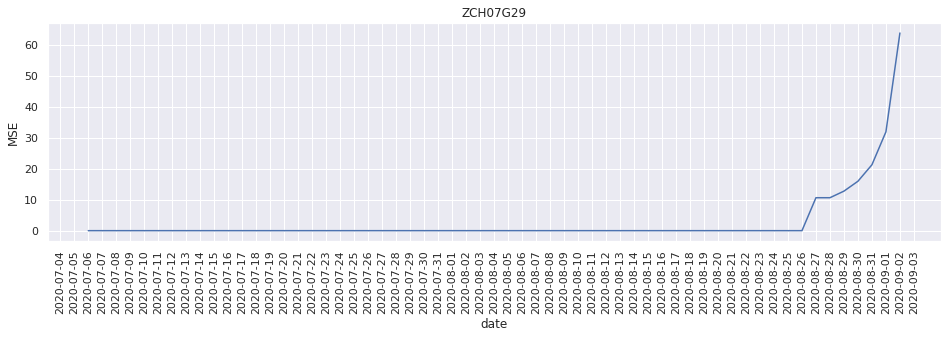

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


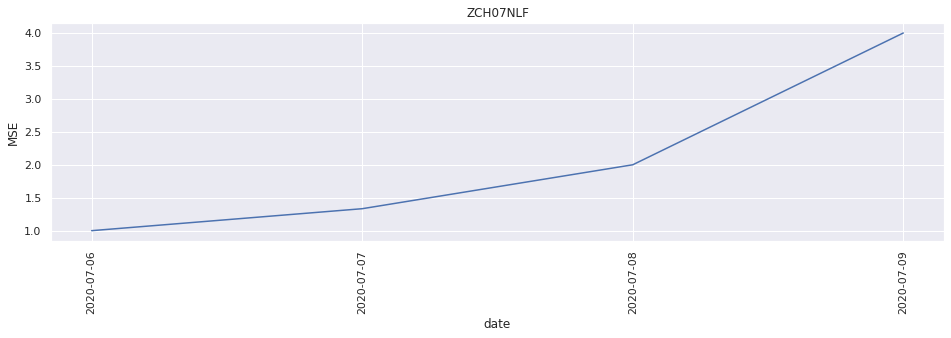

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


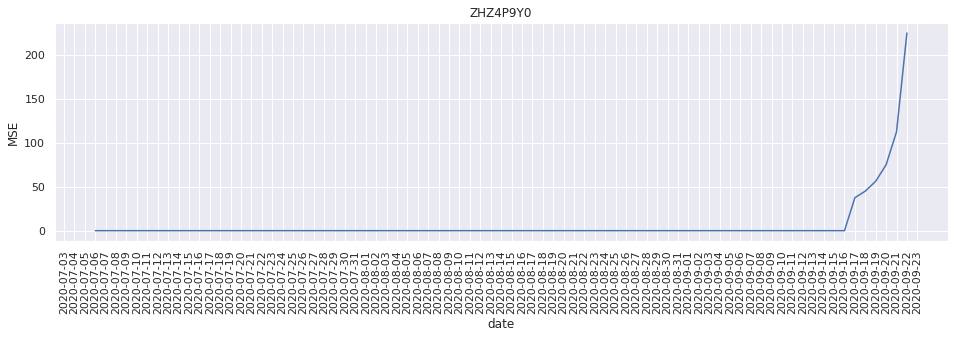

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


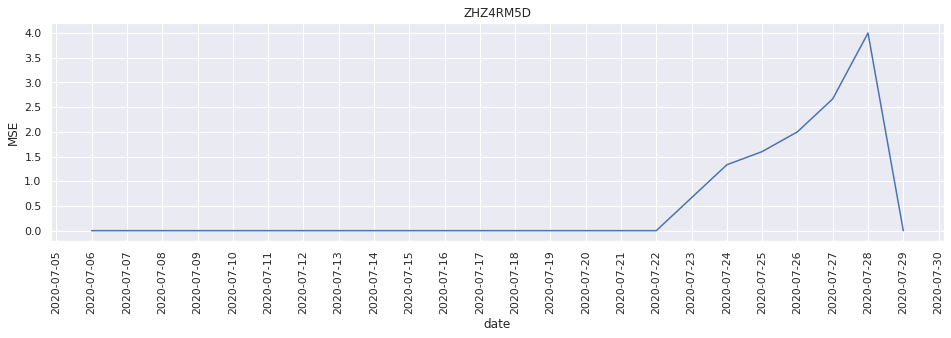

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


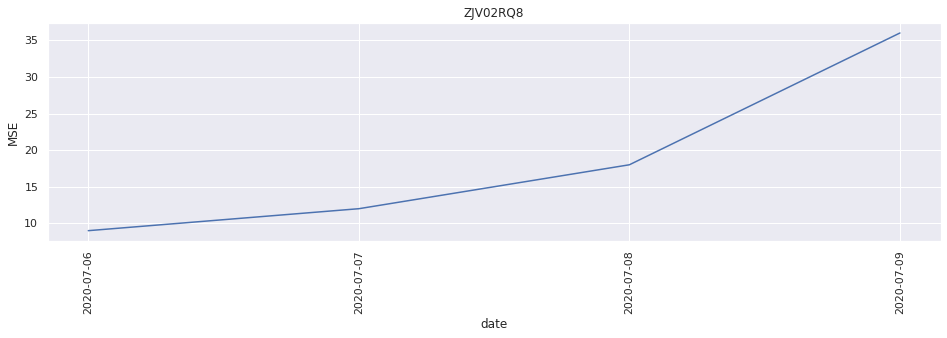

In [66]:
visualize_mses(baseline_mses, 5)

### Working Drives

In [67]:
# calculate baseline for healthy drives
baseline_mses_working = working_ts_df.groupby('serial_number').apply(get_baseline_mses_windowwise)

# df to store all results
all_mses_working = baseline_mses_working.to_frame('mse_baseline')

# average mse across days
print('Average MSE for each drive:\n\n')
display(baseline_mses_working.mean(level=0))

Average MSE for each drive:




serial_number
S300VKRB    0.0
S300VLKS    0.0
S300WE24    0.0
S300WE6K    0.0
S300WEAV    0.0
           ... 
ZHZ656DW    0.0
ZHZ65C16    0.0
ZJV009E3    0.0
ZJV00AR3    0.0
ZR50121P    NaN
Length: 136, dtype: float64

In [68]:
# what is the WORST average mse using baseline strategy
baseline_mses_working.mean(level=0).max()

0.0

## Linear Regression

In [69]:
windowwise_mses_linear = failed_ts_df.groupby('serial_number').apply(get_linreg_mses_windowwise)
calc_improvement(all_mses, windowwise_mses_linear, 'linreg_mse')

Avg. MSE for each drive:


,mse_baseline,linreg_mse
serial_number,,
ZCH07G29,2.838418,2.235782
S300Z4TZ,0.000000,0.000000
ZCH088QQ,0.000000,0.000000
ZCH08AGH,0.000000,0.000000
ZCH08ASZ,0.000000,0.000000
...,...,...
ZHZ50G0W,NaN,NaN
ZHZ5W6L4,NaN,NaN
ZL005C4H,NaN,NaN


Avg. Improvement = 0.002168270638062176

 peek at drive with most improvement


,mse_baseline,linreg_mse
date,,
2020-07-01,NaN,NaN
2020-07-02,NaN,NaN
2020-07-03,NaN,NaN
2020-07-04,NaN,NaN
2020-07-05,NaN,NaN
...,...,...
2020-08-30,16.000000,16.000000
2020-08-31,21.333333,21.333333
2020-09-01,32.000000,32.000000


## Lasso

In [70]:
windowwise_mses_lasso = failed_ts_df.groupby('serial_number').apply(get_lasso_mses_windowwise)
calc_improvement(all_mses, windowwise_mses_lasso, 'lasso_mse')

Avg. MSE for each drive:


,mse_baseline,lasso_mse
serial_number,,
ZCH07G29,2.838418,1.783804
S300Z4TZ,0.000000,0.000000
ZCH088QQ,0.000000,0.000000
ZCH08AGH,0.000000,0.000000
ZCH08ASZ,0.000000,0.000000
...,...,...
ZHZ50G0W,NaN,NaN
ZHZ5W6L4,NaN,NaN
ZL005C4H,NaN,NaN


Avg. Improvement = 0.00371839697081104

 peek at drive with most improvement


,mse_baseline,lasso_mse
date,,
2020-07-01,NaN,NaN
2020-07-02,NaN,NaN
2020-07-03,NaN,NaN
2020-07-04,NaN,NaN
2020-07-05,NaN,NaN
...,...,...
2020-08-30,16.000000,16.000000
2020-08-31,21.333333,21.333333
2020-09-01,32.000000,32.000000


## Bayesian Ridge Regression

In [71]:
windowwise_mses_br = failed_ts_df.groupby('serial_number').apply(get_br_mses_windowwise)
calc_improvement(all_mses, windowwise_mses_br, 'br_mse')

Avg. MSE for each drive:


,mse_baseline,br_mse
serial_number,,
ZCH07G29,2.838418,2.062212
S300Z4TZ,0.000000,0.000000
ZCH088QQ,0.000000,0.000000
ZCH08AGH,0.000000,0.000000
ZCH08ASZ,0.000000,0.000000
...,...,...
ZHZ50G0W,NaN,NaN
ZHZ5W6L4,NaN,NaN
ZL005C4H,NaN,NaN


Avg. Improvement = 0.00288318573879761

 peek at drive with most improvement


,mse_baseline,br_mse
date,,
2020-07-01,NaN,NaN
2020-07-02,NaN,NaN
2020-07-03,NaN,NaN
2020-07-04,NaN,NaN
2020-07-05,NaN,NaN
...,...,...
2020-08-30,16.000000,16.000000
2020-08-31,21.333333,21.333333
2020-09-01,32.000000,32.000000


## ARIMA

In [72]:
windowwise_mses_arima = failed_ts_df.groupby('serial_number').apply(get_arima_mses_windowwise)
calc_improvement(all_mses, windowwise_mses_arima, 'arima_mse')

Avg. MSE for each drive:


,mse_baseline,arima_mse
serial_number,,
S300Z4TZ,0.0,0.0
ZCH088QQ,0.0,0.0
ZCH08AGH,0.0,0.0
ZCH08ASZ,0.0,0.0
ZCH09CT2,0.0,0.0
...,...,...
ZHZ50G0W,NaN,NaN
ZHZ5W6L4,NaN,NaN
ZL005C4H,NaN,NaN


Avg. Improvement = -0.0006640456981720934

 peek at drive with most improvement


,mse_baseline,arima_mse
date,,
2020-07-01,NaN,NaN
2020-07-02,NaN,NaN
2020-07-03,NaN,NaN
2020-07-04,NaN,NaN
2020-07-05,NaN,NaN
...,...,...
2020-09-18,0.0,0.0
2020-09-19,0.0,0.0
2020-09-20,0.0,0.0


## SARIMAX

In [73]:
windowwise_mses_sarimax = failed_ts_df.groupby('serial_number').apply(get_sarimax_mses_windowwise)
calc_improvement(all_mses, windowwise_mses_sarimax, 'sarimax_mse')

Avg. MSE for each drive:


,mse_baseline,sarimax_mse
serial_number,,
S300Z4TZ,0.0,0.0
ZCH088QQ,0.0,0.0
ZCH08AGH,0.0,0.0
ZCH08ASZ,0.0,0.0
ZCH09CT2,0.0,0.0
...,...,...
ZHZ50G0W,NaN,NaN
ZHZ5W6L4,NaN,NaN
ZL005C4H,NaN,NaN


Avg. Improvement = -0.0006640456981720934

 peek at drive with most improvement


,mse_baseline,sarimax_mse
date,,
2020-07-01,NaN,NaN
2020-07-02,NaN,NaN
2020-07-03,NaN,NaN
2020-07-04,NaN,NaN
2020-07-05,NaN,NaN
...,...,...
2020-09-18,0.0,0.0
2020-09-19,0.0,0.0
2020-09-20,0.0,0.0


## Prophet

In [74]:
windowwise_mses_prophet = failed_ts_df.groupby('serial_number').apply(get_prophet_mses_windowwise)
calc_improvement(all_mses, windowwise_mses_prophet, 'prophet_mse')

Avg. MSE for each drive:


,mse_baseline,prophet_mse
serial_number,,
ZCH07G29,2.838418,2.231074
S300Z4TZ,0.000000,0.000000
ZCH088QQ,0.000000,0.000000
ZCH08AGH,0.000000,0.000000
ZCH08ASZ,0.000000,0.000000
...,...,...
ZHZ50G0W,NaN,NaN
ZHZ5W6L4,NaN,NaN
ZL005C4H,NaN,NaN


Avg. Improvement = 0.0016292468309516053

 peek at drive with most improvement


,mse_baseline,prophet_mse
date,,
2020-07-01,NaN,NaN
2020-07-02,NaN,NaN
2020-07-03,NaN,NaN
2020-07-04,NaN,NaN
2020-07-05,NaN,NaN
...,...,...
2020-08-30,16.000000,16.000000
2020-08-31,21.333333,21.333333
2020-09-01,32.000000,32.000000


From the above experiments, we can see that lasso performed a little better than the baseline model, followed by Bayesian ridge regression, linear regression, and prophet for smart 188 metric. Arima and Sarimax performed worse than the baseline model. 

# Metric SMART 197

In the following cells, we will predict the future values of the SMART 197 Metric. SMART 197 specifies the count of "unstable" sectors (waiting to be remapped, because of unrecoverable read errors). If an unstable sector is subsequently read successfully, the sector is remapped and this value is decreased.

In [75]:
# training setup config
Y_COLS = ['smart_197_normalized']
y_smart_stats = set([col.split('_')[1] for col in Y_COLS])

X_COLS = [c for c in smart_cols if c.split('_')[1] not in y_smart_stats]

NDAYS_DATA = 6
NDAYS_TO_PREDICT = 6

In [76]:
# calculate baseline
baseline_mses = failed_ts_df.groupby('serial_number').apply(get_baseline_mses_windowwise)

# df to store all results
all_mses = baseline_mses.to_frame('mse_baseline')

# average mse across days
print('Average MSE for each drive:\n\n', baseline_mses.mean(level=0), end='\n\n')


Average MSE for each drive:

 serial_number
S300WFGR           NaN
S300Z4TZ     41.323291
S300Z7P1      0.000000
S301FDQW    368.038690
S301GMWQ      0.000000
               ...    
ZLW0G6CE      0.000000
ZLW0G6FJ           NaN
ZLW0GK7E      0.000000
ZLW0GKE4      0.000000
ZLW0GPC5           NaN
Length: 272, dtype: float64



INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


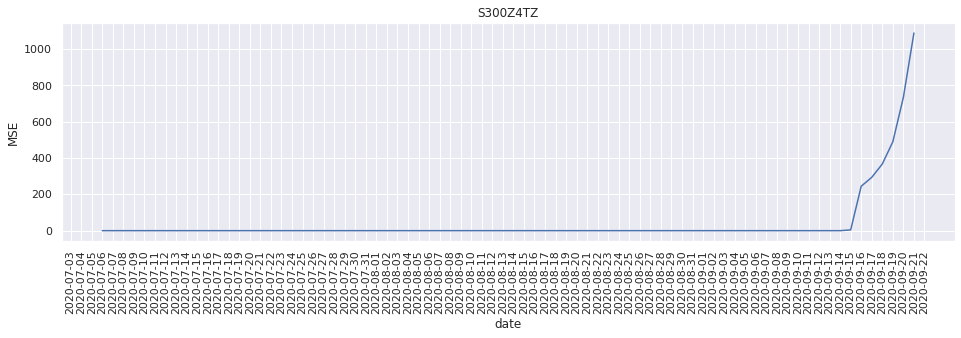

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


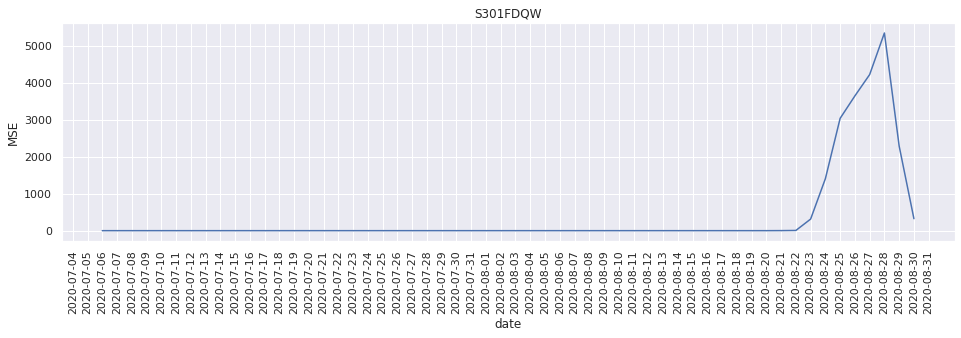

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


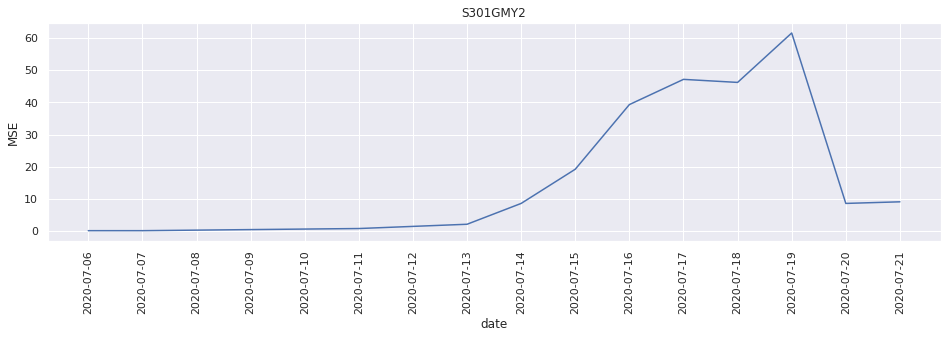

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


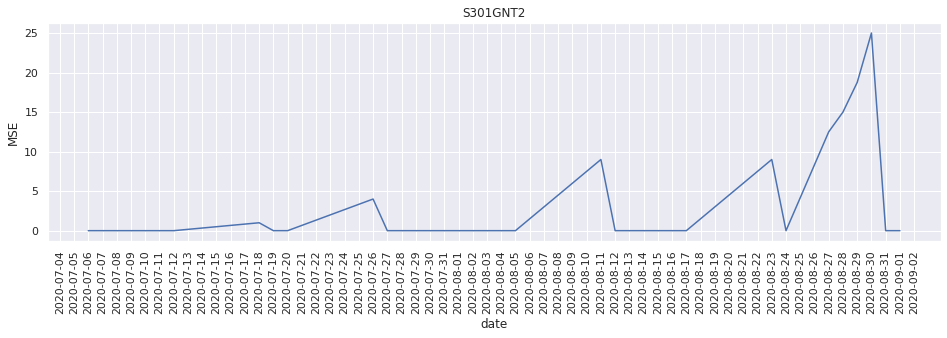

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


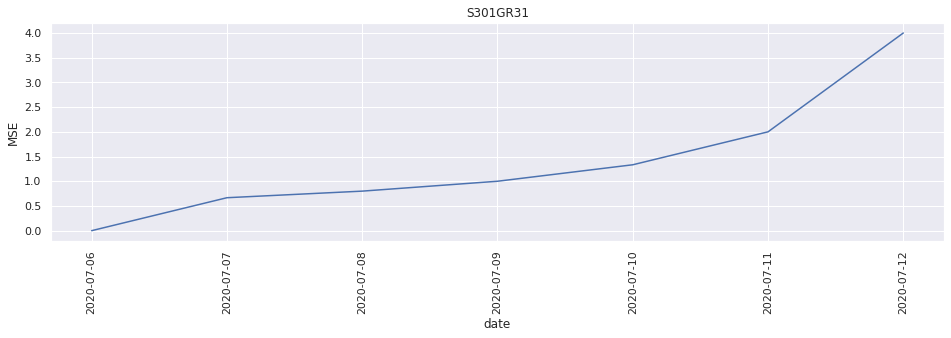

In [77]:
visualize_mses(baseline_mses, 5)

### Working Drives

In [78]:
# calculate baseline for healthy drives
baseline_mses_working = working_ts_df.groupby('serial_number').apply(get_baseline_mses_windowwise)

# df to store all results
all_mses_working = baseline_mses_working.to_frame('mse_baseline')

# average mse across days
print('Average MSE for each drive:\n\n')
display(baseline_mses_working.mean(level=0))

Average MSE for each drive:




serial_number
S300VKRB    0.0
S300VLKS    0.0
S300WE24    0.0
S300WE6K    0.0
S300WEAV    0.0
           ... 
ZHZ656DW    0.0
ZHZ65C16    0.0
ZJV009E3    0.0
ZJV00AR3    0.0
ZR50121P    NaN
Length: 136, dtype: float64

In [79]:
# what is the WORST average mse using baseline strategy
baseline_mses_working.mean(level=0).max()

0.0

## Linear Regression

In [80]:
windowwise_mses_linear = failed_ts_df.groupby('serial_number').apply(get_linreg_mses_windowwise)
calc_improvement(all_mses, windowwise_mses_linear, 'linreg_mse')

Avg. MSE for each drive:


,mse_baseline,linreg_mse
serial_number,,
ZCH07G29,293.335593,224.181284
S301GMY2,15.288542,13.293533
Z302SYFG,6.602469,5.297197
ZA1815CT,0.000000,0.000000
ZCH08ASZ,0.000000,0.000000
...,...,...
ZHZ50G0W,NaN,NaN
ZHZ5W6L4,NaN,NaN
ZL005C4H,NaN,NaN


Avg. Improvement = 0.12337602853312885

 peek at drive with most improvement


,mse_baseline,linreg_mse
date,,
2020-07-01,NaN,NaN
2020-07-02,NaN,NaN
2020-07-03,NaN,NaN
2020-07-04,NaN,NaN
2020-07-05,NaN,NaN
...,...,...
2020-08-30,3223.0,2088.944444
2020-08-31,4168.0,2882.342404
2020-09-01,324.0,572.070975


## Lasso

In [81]:
windowwise_mses_lasso = failed_ts_df.groupby('serial_number').apply(get_lasso_mses_windowwise)
calc_improvement(all_mses, windowwise_mses_lasso, 'lasso_mse')

Avg. MSE for each drive:


,mse_baseline,lasso_mse
serial_number,,
ZA1815CT,0.0,0.0
ZCH088QQ,0.0,0.0
ZCH08AGH,0.0,0.0
ZCH08ASZ,0.0,0.0
ZCH09CT2,0.0,0.0
...,...,...
ZHZ50G0W,NaN,NaN
ZHZ5W6L4,NaN,NaN
ZL005C4H,NaN,NaN


Avg. Improvement = -0.5310304881984288

 peek at drive with most improvement


,mse_baseline,lasso_mse
date,,
2020-07-01,NaN,NaN
2020-07-02,NaN,NaN
2020-07-03,NaN,NaN
2020-07-04,NaN,NaN
2020-07-05,NaN,NaN
2020-07-06,0.0,0.0
2020-07-07,0.0,0.0
2020-07-08,0.0,0.0
2020-07-09,0.0,0.0


## Bayesian Ridge Regression

In [82]:
windowwise_mses_br = failed_ts_df.groupby('serial_number').apply(get_br_mses_windowwise)
calc_improvement(all_mses, windowwise_mses_br, 'br_mse')

Avg. MSE for each drive:


,mse_baseline,br_mse
serial_number,,
ZCH07G29,293.335593,232.366355
S301GMY2,15.288542,14.023308
Z302SYFG,6.602469,5.667974
ZA1815CT,0.000000,0.000000
ZCH08ASZ,0.000000,0.000000
...,...,...
ZHZ50G0W,NaN,NaN
ZHZ5W6L4,NaN,NaN
ZL005C4H,NaN,NaN


Avg. Improvement = 0.03253268716345691

 peek at drive with most improvement


,mse_baseline,br_mse
date,,
2020-07-01,NaN,NaN
2020-07-02,NaN,NaN
2020-07-03,NaN,NaN
2020-07-04,NaN,NaN
2020-07-05,NaN,NaN
...,...,...
2020-08-30,3223.0,2138.633687
2020-08-31,4168.0,2939.613471
2020-09-01,324.0,785.562136


## ARIMA

In [83]:
windowwise_mses_arima = failed_ts_df.groupby('serial_number').apply(get_arima_mses_windowwise)
calc_improvement(all_mses, windowwise_mses_arima, 'arima_mse')

Avg. MSE for each drive:


,mse_baseline,arima_mse
serial_number,,
S301FDQW,368.038690,343.190154
ZCH07G29,293.335593,271.199328
S301GMY2,15.288542,15.239172
S300Z4TZ,41.323291,41.323277
Z3052KFM,12.445833,12.445831
...,...,...
ZHZ50G0W,NaN,NaN
ZHZ5W6L4,NaN,NaN
ZL005C4H,NaN,NaN


Avg. Improvement = 0.07091948293105635

 peek at drive with most improvement


,mse_baseline,arima_mse
date,,
2020-07-01,NaN,NaN
2020-07-02,NaN,NaN
2020-07-03,NaN,NaN
2020-07-04,NaN,NaN
2020-07-05,NaN,NaN
...,...,...
2020-08-27,4226.0,4225.999570
2020-08-28,5352.0,5130.782489
2020-08-29,2290.0,1346.610268


## SARIMAX

In [84]:
windowwise_mses_sarimax = failed_ts_df.groupby('serial_number').apply(get_sarimax_mses_windowwise)
calc_improvement(all_mses, windowwise_mses_sarimax, 'sarimax_mse')

Avg. MSE for each drive:


,mse_baseline,sarimax_mse
serial_number,,
S301FDQW,368.038690,343.190154
ZCH07G29,293.335593,271.199328
S301GMY2,15.288542,15.239172
S300Z4TZ,41.323291,41.323277
Z3052KFM,12.445833,12.445831
...,...,...
ZHZ50G0W,NaN,NaN
ZHZ5W6L4,NaN,NaN
ZL005C4H,NaN,NaN


Avg. Improvement = 0.07091948293105635

 peek at drive with most improvement


,mse_baseline,sarimax_mse
date,,
2020-07-01,NaN,NaN
2020-07-02,NaN,NaN
2020-07-03,NaN,NaN
2020-07-04,NaN,NaN
2020-07-05,NaN,NaN
...,...,...
2020-08-27,4226.0,4225.999570
2020-08-28,5352.0,5130.782489
2020-08-29,2290.0,1346.610268


## Prophet

In [85]:
windowwise_mses_prophet = failed_ts_df.groupby('serial_number').apply(get_prophet_mses_windowwise)
calc_improvement(all_mses, windowwise_mses_prophet, 'prophet_mse')

Avg. MSE for each drive:


,mse_baseline,prophet_mse
serial_number,,
ZCH07G29,293.335593,212.247761
S301GMY2,15.288542,11.689198
S301FDQW,368.038690,364.956980
Z302SYFG,6.602469,5.582433
S300Z4TZ,41.323291,40.844045
...,...,...
ZHZ50G0W,NaN,NaN
ZHZ5W6L4,NaN,NaN
ZL005C4H,NaN,NaN


Avg. Improvement = 0.22124409291941446

 peek at drive with most improvement


,mse_baseline,prophet_mse
date,,
2020-07-01,NaN,NaN
2020-07-02,NaN,NaN
2020-07-03,NaN,NaN
2020-07-04,NaN,NaN
2020-07-05,NaN,NaN
...,...,...
2020-08-30,3223.0,2090.197908
2020-08-31,4168.0,2882.460092
2020-09-01,324.0,574.886147


From the above experiments it seems like the Prophet model outperforms the rest for SMART 197 metric. However, a simple OLS model works quite well too with its average MSE not too far away from that of Prophet.

# Metric SMART 198

In the following cells, we will predict the future values of the SMART 198 Metric. SMART 198 specifies the total count of uncorrectable errors when reading/writing a sector. A rise in the value of this attribute indicates defects of the disk surface and/or problems in the mechanical subsystem.

In [86]:
# training setup config
Y_COLS = ['smart_198_normalized']
y_smart_stats = set([col.split('_')[1] for col in Y_COLS])

X_COLS = [c for c in smart_cols if c.split('_')[1] not in y_smart_stats]

NDAYS_DATA = 6
NDAYS_TO_PREDICT = 6

In [87]:
# calculate baseline
baseline_mses = failed_ts_df.groupby('serial_number').apply(get_baseline_mses_windowwise)

# df to store all results
all_mses = baseline_mses.to_frame('mse_baseline')

# average mse across days
print('Average MSE for each drive:\n\n', baseline_mses.mean(level=0), end='\n\n')

Average MSE for each drive:

 serial_number
S300WFGR           NaN
S300Z4TZ     41.323291
S300Z7P1      0.000000
S301FDQW    368.038690
S301GMWQ      0.000000
               ...    
ZLW0G6CE      0.000000
ZLW0G6FJ           NaN
ZLW0GK7E      0.000000
ZLW0GKE4      0.000000
ZLW0GPC5           NaN
Length: 272, dtype: float64



INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


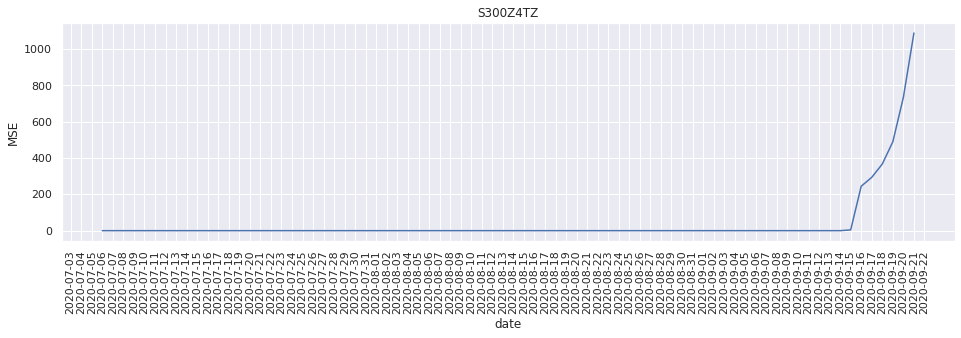

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


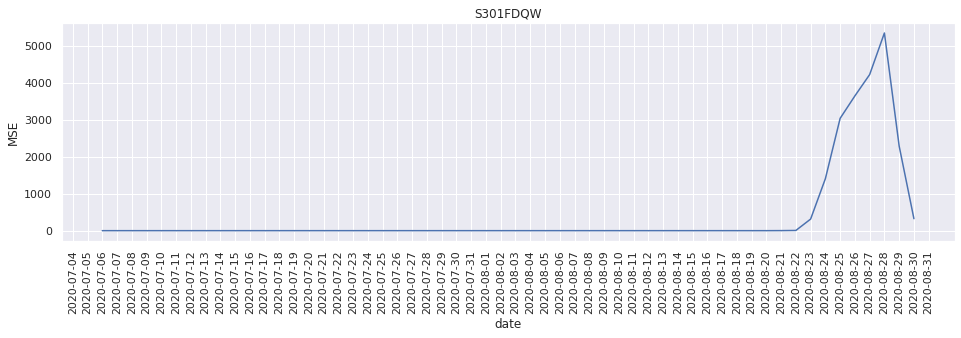

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


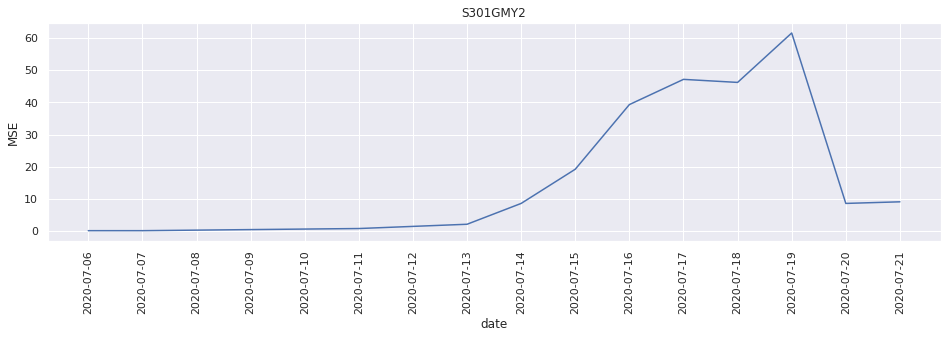

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


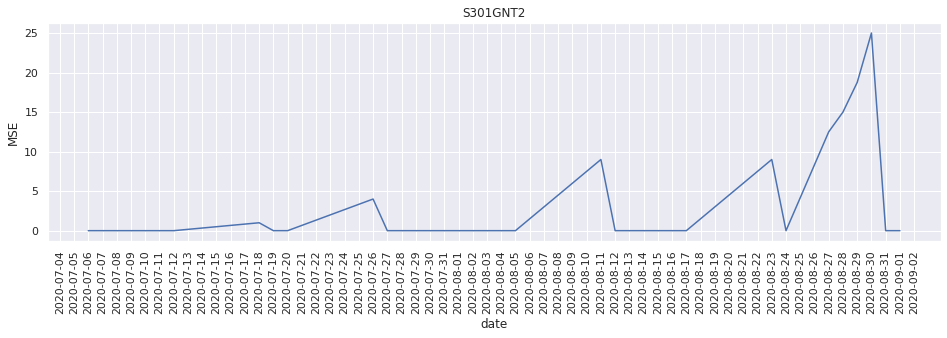

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


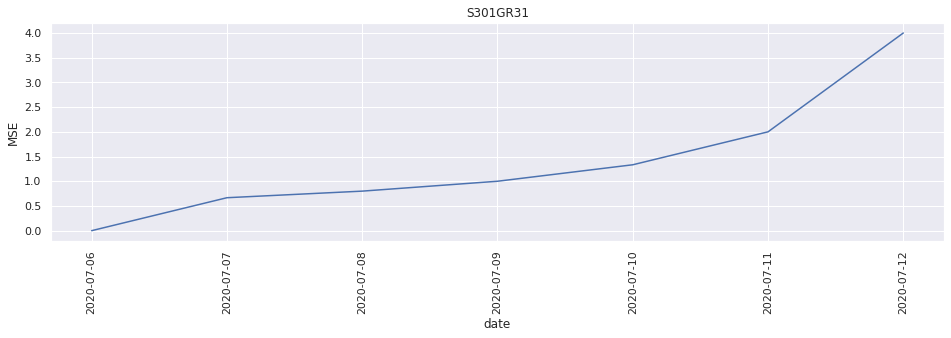

In [88]:
visualize_mses(baseline_mses, 5)

In [89]:
# calculate baseline for healthy drives
baseline_mses_working = working_ts_df.groupby('serial_number').apply(get_baseline_mses_windowwise)

# df to store all results
all_mses_working = baseline_mses_working.to_frame('mse_baseline')

# average mse across days
print('Average MSE for each drive:\n\n')
display(baseline_mses_working.mean(level=0))

Average MSE for each drive:




serial_number
S300VKRB    0.0
S300VLKS    0.0
S300WE24    0.0
S300WE6K    0.0
S300WEAV    0.0
           ... 
ZHZ656DW    0.0
ZHZ65C16    0.0
ZJV009E3    0.0
ZJV00AR3    0.0
ZR50121P    NaN
Length: 136, dtype: float64

In [90]:
# what is the WORST average mse using baseline strategy
baseline_mses_working.mean(level=0).max()

0.0

## Linear Regression

In [91]:
windowwise_mses_linear = failed_ts_df.groupby('serial_number').apply(get_linreg_mses_windowwise)
calc_improvement(all_mses, windowwise_mses_linear, 'linreg_mse')

Avg. MSE for each drive:


,mse_baseline,linreg_mse
serial_number,,
ZCH07G29,293.335593,224.181284
S301GMY2,15.288542,13.293533
Z302SYFG,6.602469,5.297197
ZA1815CT,0.000000,0.000000
ZCH08ASZ,0.000000,0.000000
...,...,...
ZHZ50G0W,NaN,NaN
ZHZ5W6L4,NaN,NaN
ZL005C4H,NaN,NaN


Avg. Improvement = 0.12337602853312885

 peek at drive with most improvement


,mse_baseline,linreg_mse
date,,
2020-07-01,NaN,NaN
2020-07-02,NaN,NaN
2020-07-03,NaN,NaN
2020-07-04,NaN,NaN
2020-07-05,NaN,NaN
...,...,...
2020-08-30,3223.0,2088.944444
2020-08-31,4168.0,2882.342404
2020-09-01,324.0,572.070975


## Lasso

In [92]:
windowwise_mses_lasso = failed_ts_df.groupby('serial_number').apply(get_lasso_mses_windowwise)
calc_improvement(all_mses, windowwise_mses_lasso, 'lasso_mse')

Avg. MSE for each drive:


,mse_baseline,lasso_mse
serial_number,,
ZA1815CT,0.0,0.0
ZCH088QQ,0.0,0.0
ZCH08AGH,0.0,0.0
ZCH08ASZ,0.0,0.0
ZCH09CT2,0.0,0.0
...,...,...
ZHZ50G0W,NaN,NaN
ZHZ5W6L4,NaN,NaN
ZL005C4H,NaN,NaN


Avg. Improvement = -0.5310304881984288

 peek at drive with most improvement


,mse_baseline,lasso_mse
date,,
2020-07-01,NaN,NaN
2020-07-02,NaN,NaN
2020-07-03,NaN,NaN
2020-07-04,NaN,NaN
2020-07-05,NaN,NaN
2020-07-06,0.0,0.0
2020-07-07,0.0,0.0
2020-07-08,0.0,0.0
2020-07-09,0.0,0.0


## Bayesian Ridge Regression

In [93]:
windowwise_mses_br = failed_ts_df.groupby('serial_number').apply(get_br_mses_windowwise)
calc_improvement(all_mses, windowwise_mses_br, 'br_mse')

Avg. MSE for each drive:


,mse_baseline,br_mse
serial_number,,
ZCH07G29,293.335593,232.366355
S301GMY2,15.288542,14.023308
Z302SYFG,6.602469,5.667974
ZA1815CT,0.000000,0.000000
ZCH08ASZ,0.000000,0.000000
...,...,...
ZHZ50G0W,NaN,NaN
ZHZ5W6L4,NaN,NaN
ZL005C4H,NaN,NaN


Avg. Improvement = 0.03253268716345691

 peek at drive with most improvement


,mse_baseline,br_mse
date,,
2020-07-01,NaN,NaN
2020-07-02,NaN,NaN
2020-07-03,NaN,NaN
2020-07-04,NaN,NaN
2020-07-05,NaN,NaN
...,...,...
2020-08-30,3223.0,2138.633687
2020-08-31,4168.0,2939.613471
2020-09-01,324.0,785.562136


## ARIMA

In [94]:
windowwise_mses_arima = failed_ts_df.groupby('serial_number').apply(get_arima_mses_windowwise)
calc_improvement(all_mses, windowwise_mses_arima, 'arima_mse')

Avg. MSE for each drive:


,mse_baseline,arima_mse
serial_number,,
S301FDQW,368.038690,343.190154
ZCH07G29,293.335593,271.199328
S301GMY2,15.288542,15.239172
S300Z4TZ,41.323291,41.323277
Z3052KFM,12.445833,12.445831
...,...,...
ZHZ50G0W,NaN,NaN
ZHZ5W6L4,NaN,NaN
ZL005C4H,NaN,NaN


Avg. Improvement = 0.07091948293105635

 peek at drive with most improvement


,mse_baseline,arima_mse
date,,
2020-07-01,NaN,NaN
2020-07-02,NaN,NaN
2020-07-03,NaN,NaN
2020-07-04,NaN,NaN
2020-07-05,NaN,NaN
...,...,...
2020-08-27,4226.0,4225.999570
2020-08-28,5352.0,5130.782489
2020-08-29,2290.0,1346.610268


## SARIMAX

In [95]:
windowwise_mses_sarimax = failed_ts_df.groupby('serial_number').apply(get_sarimax_mses_windowwise)
calc_improvement(all_mses, windowwise_mses_sarimax, 'sarimax_mse')

Avg. MSE for each drive:


,mse_baseline,sarimax_mse
serial_number,,
S301FDQW,368.038690,343.190154
ZCH07G29,293.335593,271.199328
S301GMY2,15.288542,15.239172
S300Z4TZ,41.323291,41.323277
Z3052KFM,12.445833,12.445831
...,...,...
ZHZ50G0W,NaN,NaN
ZHZ5W6L4,NaN,NaN
ZL005C4H,NaN,NaN


Avg. Improvement = 0.07091948293105635

 peek at drive with most improvement


,mse_baseline,sarimax_mse
date,,
2020-07-01,NaN,NaN
2020-07-02,NaN,NaN
2020-07-03,NaN,NaN
2020-07-04,NaN,NaN
2020-07-05,NaN,NaN
...,...,...
2020-08-27,4226.0,4225.999570
2020-08-28,5352.0,5130.782489
2020-08-29,2290.0,1346.610268


## Prophet

In [96]:
windowwise_mses_prophet = failed_ts_df.groupby('serial_number').apply(get_prophet_mses_windowwise)
calc_improvement(all_mses, windowwise_mses_prophet, 'prophet_mse')

Avg. MSE for each drive:


,mse_baseline,prophet_mse
serial_number,,
ZCH07G29,293.335593,212.247761
S301GMY2,15.288542,11.689198
S301FDQW,368.038690,364.956980
Z302SYFG,6.602469,5.582433
S300Z4TZ,41.323291,40.844045
...,...,...
ZHZ50G0W,NaN,NaN
ZHZ5W6L4,NaN,NaN
ZL005C4H,NaN,NaN


Avg. Improvement = 0.22124409291941446

 peek at drive with most improvement


,mse_baseline,prophet_mse
date,,
2020-07-01,NaN,NaN
2020-07-02,NaN,NaN
2020-07-03,NaN,NaN
2020-07-04,NaN,NaN
2020-07-05,NaN,NaN
...,...,...
2020-08-30,3223.0,2090.197908
2020-08-31,4168.0,2882.460092
2020-09-01,324.0,574.886147


From the above experiments it seems like the Prophet model outperforms the rest for SMART 198 metric. However, a simple OLS model works quite well too with its average MSE not too far away from that of Prophet.

# Conclusion
In this notebook, we tried to predict future values of SMART 5, 187, 188, 197, 198 metrics using different machine learning models. In general, we found out the ml models give better results than the baseline models. Prophet models outperform other models for SMART 5, 197, 198 metrics. However, no single model performed better than the baseline model for all the metrics. Hence, based on metrics, we will select different ml models. 